# Introduction

This notebook aims to solve a multiclass classification problem using CNN on the Fashion MNIST dataset. In order to achieve the best results, this notebook follows the universal workflow of machine learning and implements advanced deel-learning practices such as Keras callbacks.


### 1. Defining the problem, the dataset and measure of success

Similart to the original MNIST dataset, the Fashion MNIST dataset comes with 60000 training images and 10000 test images, each belonging to a single label of 10 different classes. The goal of the network is to correctly classify as many training images to their true labels as possible. Since each of the images will be classified to a single label, this is a single-label, multiclass classification problem.

Hypotheses: 
1. The outputs can be predicted by the given inputs.
2. The avaiable data is sufficiently informative to learn the relationship between inputs and outputs.

The measure of success is measured by the validation accuracy of the model.

In [29]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

2.1.0


### 2. Deciding on evaulation protocol
Mantaining a hold-out validation set would be the optimal choice since the Fashion MNIST dataset contains a lot of training examples.

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('train length:', len(train_images))

train length: 60000


In [3]:
# Defining the labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

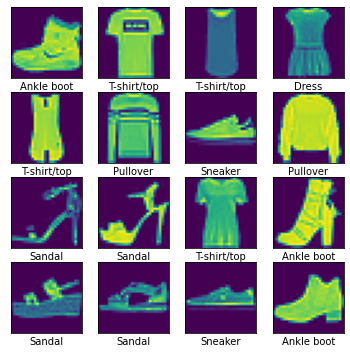

In [4]:
# Displaying some of the train images and their labels
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 3. Preparing the data
Each image consists of 28x28 pixels and each pixel is assosiated with an integer between 0-255 that indicates how dark the pixel is. Since each pixel has a value between 0-255, it needs to be normalized.

In [5]:
print('train shape:', train_images.shape)
print('test shape:', test_images.shape)

train shape: (60000, 28, 28)
test shape: (10000, 28, 28)


In [6]:
print(train_images[:1])

[[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73
     0   0   1   4   0   0   0   0   1   1   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127
    62  54   0   0   0   1   3   4   0   0   3]
  [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176
   134 144 123  23   0   0   0   0  12  10   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207
   178 107 156 161 109  64  23  77 130  72  15]
  [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218
   216 216 163 127 121 122 146 141  88 172  66]
  [  0   0   0   0   0   0   0   0   0   1   1  

The labels are stored in list, looking at the first 100 examples, each label takes a value between 0 and 9

In [7]:
print(train_labels[0:100])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6 6 7 9 5 9 2 7 3 0 3 3 3 7 2 2 6 6 8 3 3 5 0 5 5 0 2 0 0 4 1 3 1 6 3
 1 4 4 6 1 9 1 3 5 7 9 7 1 7 9 9 9 3 2 9 3 6 4 1 1 8]


Before the data can be fed into the model it needs to be preprocessed. Reshaping the data so that all values are in the [0, 1] range.

One-hot is used to vectorize the labels, it embeds each label as a vector with all zeroes except the place of the label index, which is indicated with a 1.

In [8]:
from tensorflow.keras.utils import to_categorical

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

one_hot_train_labels = to_categorical(train_labels, 10)
one_hot_test_labels = to_categorical(test_labels, 10)

In [9]:
# Example of how the one-hot label looks like
print(one_hot_train_labels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Split the first 15% of the training data into a validation set, the model is then trained on the partial training data and evaluated on the validation data. This way the model does not have access to any information about the test data.

In [10]:
# 15% for the val split
val_split = round((len(train_images) / 100) * 15)

x_val = train_images[:val_split]
partial_x_train = train_images[val_split:]

y_val = one_hot_train_labels[:val_split]
partial_y_train = one_hot_train_labels[val_split:]

In [11]:
print('training:', len(partial_x_train))
print('validation:', len(x_val))
print('test:', len(test_images))

training: 51000
validation: 9000
test: 10000


### 4. Building the model

The first goal of the model is to achieve statistical power, meaning beating a random baseline. A completely random baseline achievies around 0.1 accuracy, because the data is split between all classes reletevely evenly. If the model just barely beats the baseline it would not be very useful, but it is a start in the right direction.

In [12]:
# Random baseline model from the book
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle (test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len (test_labels)

0.1026

Since the model will classify images into 10 different categories, the output layer of the model must be of size 10. The output layer should also use a 'softmax' activation so that it will output a probability distribution over the 10 different classes for a given image.

The intermediate layers of the model consist of stacking Conv2D and MaxPooling2D layers. Tests were made by changing the size of the model by adding/removing Conv2D layers and changing their number of channels as well as experimenting with BatchNormalization and Dropout layers.

The last output of the Conv2D layers is Flattened and then fed into a densley connected model.

The role of the MaxPooling2D layers are to downsample the feature maps from the Conv2D layers by half.

In [178]:
from tensorflow.keras import models, layers
   
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_57 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 8, 8, 64)        

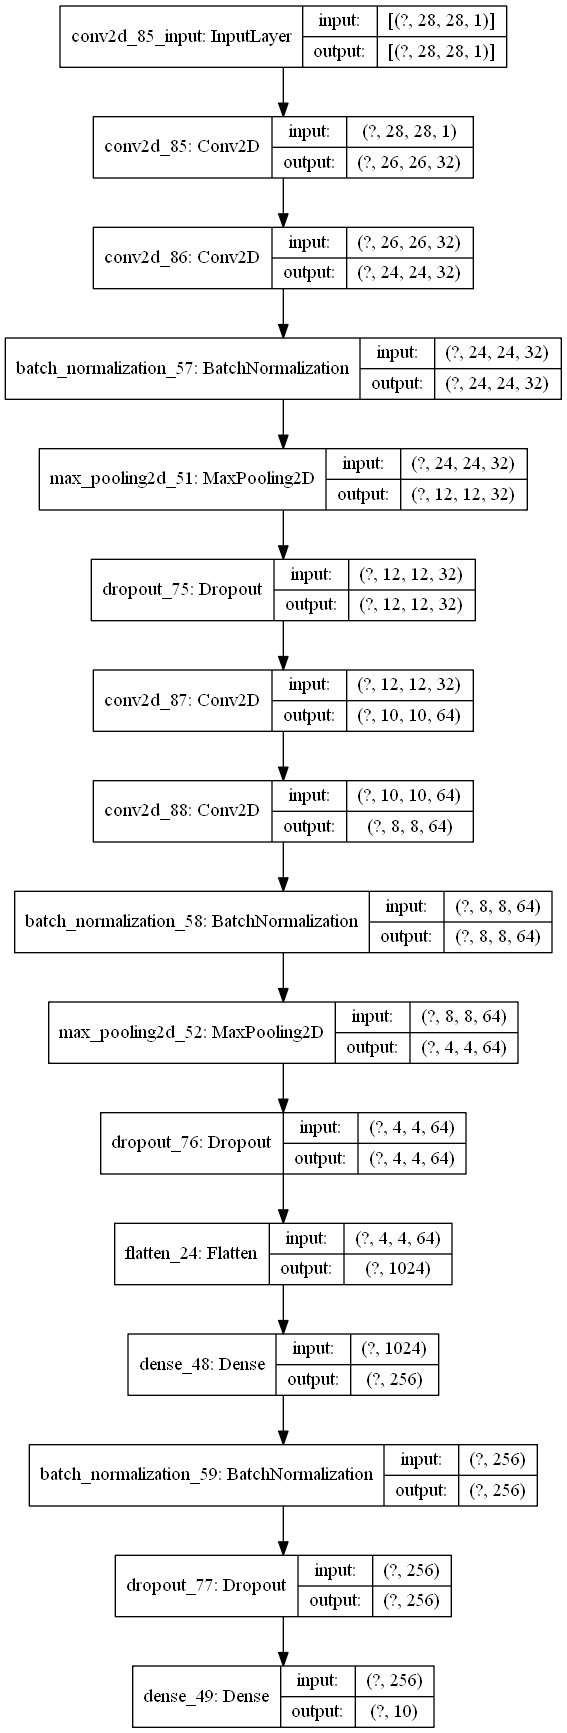

In [179]:
# Visualised model
tf.keras.utils.plot_model(model, show_shapes=True)

The optimizer used for the first few tests was 'rmsprop' as it it soncidered th safest and most commonly used for classification problems, however it was later on changed to 'adam' as it produced better results. Comparison of the results from 'rmsprop' and 'adam' can be found further down the notebook.

The loss function for is "categorical_crossentropy" as it measures the distance
between two probability distributions, in this case, between the probability distribution of the
output layer and the real distribution of the labels.

In [180]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

Experiments were made with the callback functions EarlyStopping and ReduceLROnPlateau. Before implementing the EarlyStopping callback all of the models were trained for 20 epochs and most of the time it was either not enough or wasting time. It helped saving time when training the model.

Due to lack of knowledge and experience with the ReduceLROnPlateau callback function it did not benefit the model, in some cases it even made the model perform worse.

In [181]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
     monitor = 'val_accuracy',
     patience = 8,
     )
]

history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs = 40,
                    batch_size = 256,
                    callbacks = callbacks_list,
                    validation_data = (x_val, y_val))

Train on 51000 samples, validate on 9000 samples
Epoch 1/40
51000/51000 [==============================] - 6s 114us/sample - loss: 0.5698 - accuracy: 0.7938 - val_loss: 3.0681 - val_accuracy: 0.2486
Epoch 2/40
51000/51000 [==============================] - 4s 87us/sample - loss: 0.3569 - accuracy: 0.8694 - val_loss: 1.3264 - val_accuracy: 0.5876
Epoch 3/40
51000/51000 [==============================] - 4s 80us/sample - loss: 0.3053 - accuracy: 0.8868 - val_loss: 0.3586 - val_accuracy: 0.8654
Epoch 4/40
51000/51000 [==============================] - 4s 80us/sample - loss: 0.2726 - accuracy: 0.8995 - val_loss: 0.2459 - val_accuracy: 0.9081
Epoch 5/40
51000/51000 [==============================] - 4s 80us/sample - loss: 0.2507 - accuracy: 0.9083 - val_loss: 0.2251 - val_accuracy: 0.9150
Epoch 6/40
51000/51000 [==============================] - 4s 79us/sample - loss: 0.2360 - accuracy: 0.9133 - val_loss: 0.2320 - val_accuracy: 0.9123
Epoch 7/40
51000/51000 [==============================] 

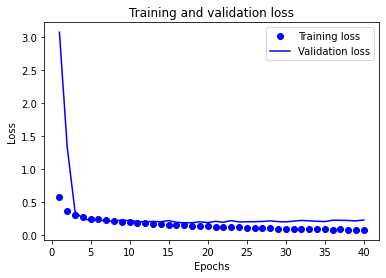

In [182]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range (1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('cw2plot/loss/SConv64-SConv64-Do-SConv128-SConv128-Do-Den256-Do.png', dpi=300, bbox_inches='tight')
plt.show()

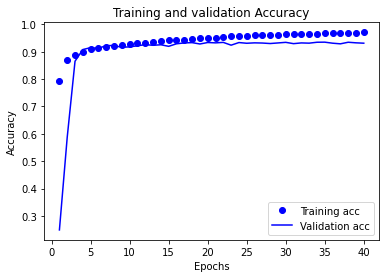

In [183]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range (1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plt.savefig('cw2plot/acc/SConv64-SConv64-Do-SConv128-SConv128-Do-Den256-Do.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Evaluating models with different number of layers and sizes
An ideal model would be considered one that stands right between undefitting and overfitting. In order to find out when that happens, the first step would be to develop a model that overfits, this can be achieved by adding more layers and increasing the size and the number of channels.

The table below shows all the experiments done with different number of layers and sizes. As
well as regularizing the model by tunning the hyperparameters, adding Dropout and BatchNormalization.

In [163]:
import pandas as pd

# Comparing the validation loss and Acc with different network layers and sizes

# Conv2D layers are defined with 'Conv' followed by the number of channels for example: 'Conv16'
# Dense layers are defined with a 'Den': for example: 'Den128'
# Dropout layers are defined with a 'Do'
# Assuming that each Conv2D layer is followed by a MaxPooling2D(2,2) layer unless stated otherwise
# The last layer of the model is a Dense layer of size 10, it is not being noted down to avoid repetition

data = [ ['2 Conv Layers + 1 Dense Layers', '' , '' , ''],
        ['Conv16-Conv32-Den64', 0.910, 0.254, 'Small overfitting'],
        ['Conv32-Conv64-Den128', 0.915, 0.281, 'More overfitting'],
        ['Conv64-Conv128-Den256', 0.919, 0.250, 'Quite big a model, heavy overfitting'],
        ['', '' , '' , ''],
        ['2 Conv Layers + 1 Dense Layers + Dropout(0.25)', '' , '' , ''],
        ['Conv16-Do-Conv32-Do-Den64-Do', 0.908, 0.252, 'Model is too small, underfits a lot'],
        ['Conv32-Do-Conv64-Do-Den128-Do', 0.919, 0.225, 'Small underfitting'],
        ['Conv64-Do-Conv128-Do-Den256-Do', 0.924, 0.218, 'Slighly better results with bigger model'],
        ['', '' , '' , ''],
        ['4 Conv Layers 2 stacks of 2, + 1 Dense Layer + Dropout(0.25)', '' , '' , ''],
        ['Conv32-Conv32-Do-Conv64-Conv64-Do-Den256-Do', 0.928, 0.196, 'Stacking conv layers improved acc'],
        ['Conv64-Conv64-Do-Conv128-Conv128-Do-Den256-Do', 0.932, 0.199, 'Slight increase in acc, some overfitting'],
        ['', '' , '' , ''],
        ['4 Conv Layers + BatchNormalization + Dropout(0.25)', '' , '' , ''],
        ['Conv32-Conv32-BN-Do-Conv64-Conv64-BN-Do-Den256-BN-Do', 0.935, 0.190, 'Batch Normalization improved acc'],
        ['Conv64-Conv64-BN-Do-Conv128-Conv128-BN-Do-Den256-BN-Do', 0.932, 0.228,'Worse results, decrease in acc'],
        ['', '' , '' , ''],
        ['DepthWise Separable Convulation model', '' , '' , ''],
        ['SConv32-SConv32-Do-SConv64-SConv64-Do-Den256-Do', 0.923, 0.201,'Separable Conv achived worse result'],
        ['SConv32-SConv32-Do-SConv64-SConv64-Do-Den256-Do', 0.918, 0.249,'Even worse results'],
        ['', '' , '' , ''],
        ['The best model + rmsprop optimizer', '' , '' , ''],
        ['rmsprop-Conv64-Conv64-BN-Do-Conv128-Conv128-BN-Do-Den256-BN-Do', 0.931, 0.191,'Slight worse results compared to adam'],
       ]

pd.DataFrame(data, columns=["Network Layers", "val_acc", 'val_loss', 'Comment'])

,Network Layers,val_acc,val_loss,Comment
0,2 Conv Layers + 1 Dense Layers,,,
1,Conv16-Conv32-Den64,0.91,0.254,Small overfitting
2,Conv32-Conv64-Den128,0.915,0.281,More overfitting
3,Conv64-Conv128-Den256,0.919,0.25,"Quite big a model, heavy overfitting"
4,,,,
5,2 Conv Layers + 1 Dense Layers + Dropout(0.25),,,
6,Conv16-Do-Conv32-Do-Den64-Do,0.908,0.252,"Model is too small, underfits a lot"
7,Conv32-Do-Conv64-Do-Den128-Do,0.919,0.225,Small underfitting
8,Conv64-Do-Conv128-Do-Den256-Do,0.924,0.218,Slighly better results with bigger model
9,,,,


### 6. Comparing graphs for some of the worst and best models
All of the model's graphs were saved in the 'cw2plot' folder uner 'loss' and 'acc' the name of each graph corresponds to the name of the model in the table. For example the loss graph of the Conv16-Conv32-Den64 model is saved under 'cw2plot/loss/Conv16-Conv32-Den64'

The first example shown below are of models that overfit a lot due to the lack of Dropout layers and the big size of the layers. 

In [57]:
def plot_img(img, img2):
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plot_image = np.concatenate((img, img2), axis=1)
    plt.imshow(plot_image)
    plt.show()

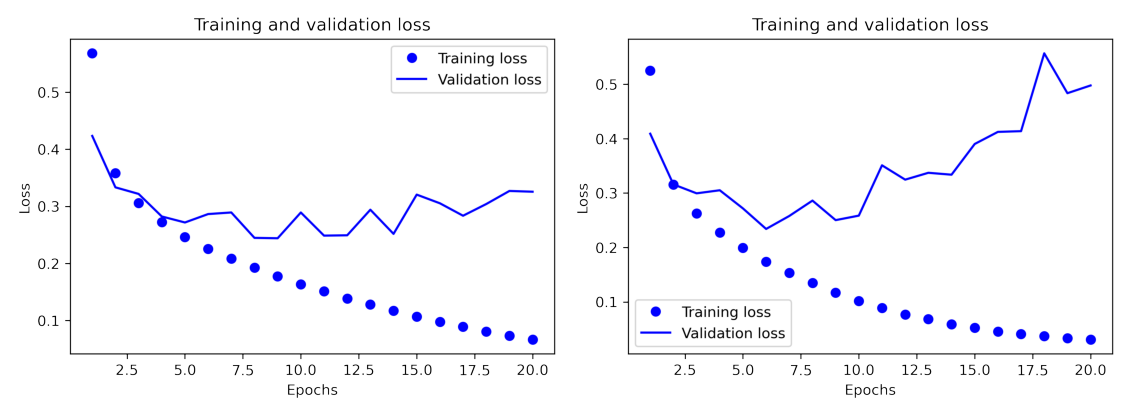

In [59]:
# Loss graph of the Conv32-Conv64-Den128 and Conv64-Conv128-Den256 model
import matplotlib.image as mpimg
img = mpimg.imread('cw2plot/loss/Conv32-Conv64-Den128.png')
img2 = mpimg.imread('cw2plot/loss/Conv64-Conv128-Den256.png')
plot_img(img, img2)

The examples below show the same models but with the addition of Dropout(0.25) layers that significantly reduced overfitting.

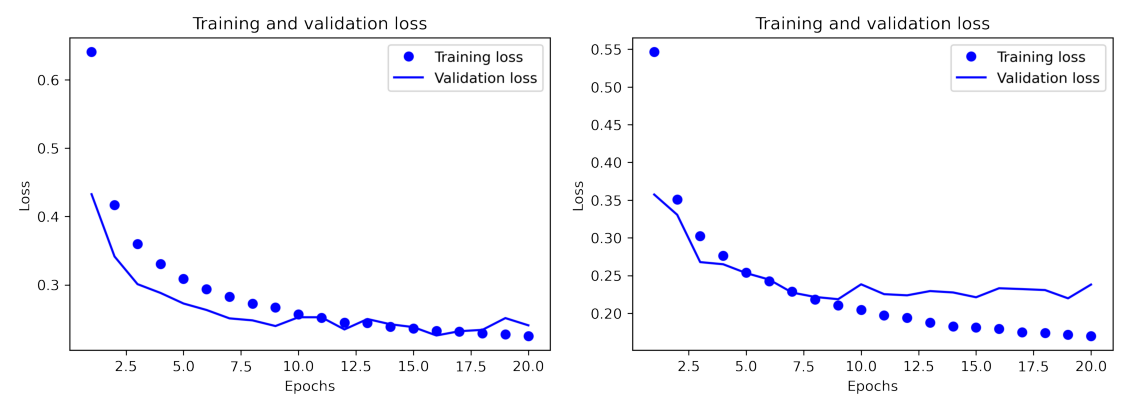

In [61]:
# Dropout example
img = mpimg.imread('cw2plot/loss/Conv32-Do-Conv64-Do-Den128-Do.png')
img2 = mpimg.imread('cw2plot/loss/Conv64-Do-Conv128-Do-Den256-Do.png')
plot_img(img, img2)

The first example below shows how stacking 2 Conv2D layers on top of each other along with Dropout produce even better results compared to the previous models. 

The second graph is a model built with Depthwise Separable Convolution, it achives slightly better results comparted to the Conv2D model.

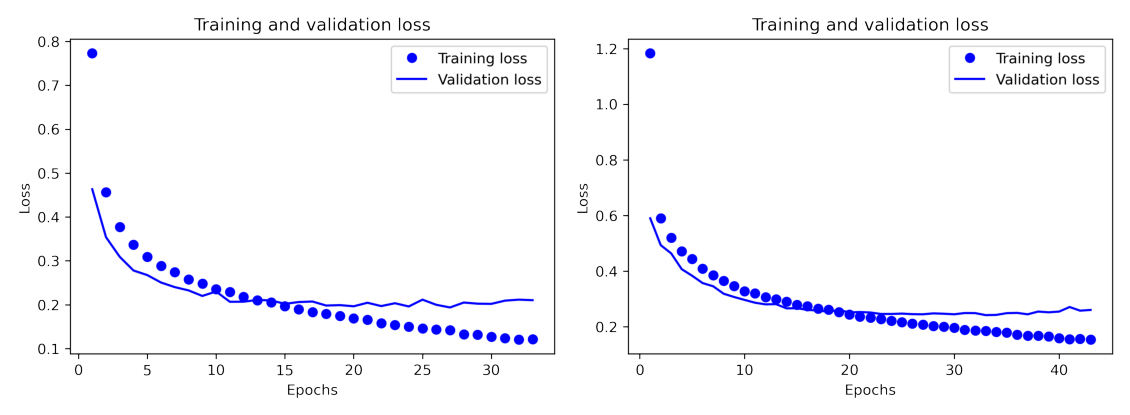

In [161]:
# Conv2D 2 stacked layers and Depthwise Separable Convolution model
img = mpimg.imread('cw2plot/loss/Conv32-Conv32-Do-Conv64-Conv64-Do-Den256-Do.png')
img2 = mpimg.imread('cw2plot/loss/SConv64-SConv64-Do-SConv128-SConv128-Do-Den256-Do.png')
plot_img(img, img2)

Batch Normalization graphs, the model with smaller number of channels performs better. Batch Normalization slightly increased validation accuracy compared to the same model without Batch Normalization. It also achieved better result compared to the Depthwise Convolution model.
This is the best model so far.

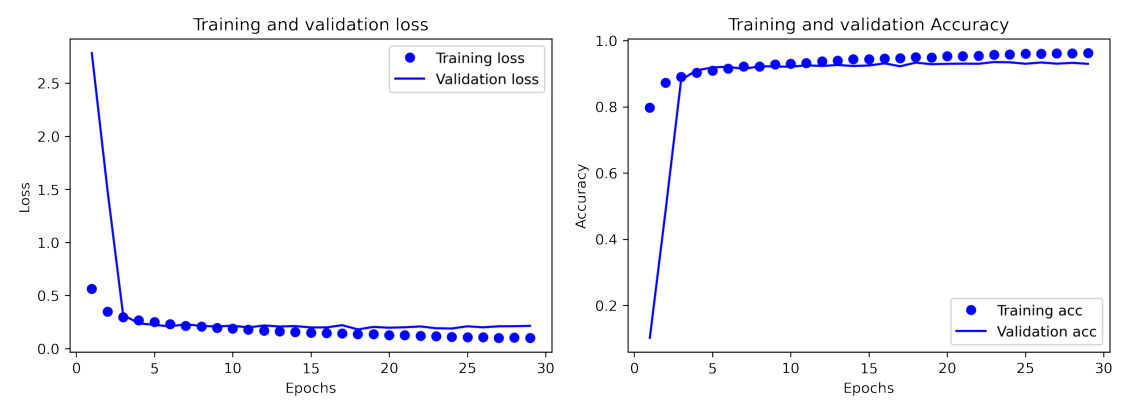

In [162]:
# Loss and Acc Graphs of the best model
img = mpimg.imread('cw2plot/loss/Conv32-Conv32-BN-Do-Conv64-Conv64-BN-Do-Den256-BN-Do.png')
img2 = mpimg.imread('cw2plot/acc/Conv32-Conv32-BN-Do-Conv64-Conv64-BN-Do-Den256-BN-Do.png')
plot_img(img, img2)

The best solution for reducing overfitting was the addition of the Dropout layer and Batch Normalization along with stacking Conv2D layers. 

The 'adam' optimizer generally achieved better results compared to 'rmsprop'.

The experiment with the Depthwise Separable Convolution model ahieved slightly better results in terms of overfitting compared to the normal Conv2D model. However, it achieved worse results compared to the normal Conv2D model with Batch Normalization.

### 7. Using the best model to evaluate on the test data
After discovering the best model (Conv2D stacked layers with Dropout and Batch Normalziation) and the optimal training epochs, the next step is to retrain the model with the entire training set and finally evaluate on the test data.

In [186]:
print(np.argmax(val_acc), 'epochs')

34 epochs


In [193]:
final_model = models.Sequential()
final_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
final_model.add(layers.Conv2D(32, (3,3), activation='relu'))
final_model.add(layers.BatchNormalization())
final_model.add(layers.MaxPooling2D(2,2))
final_model.add(layers.Dropout(0.25))

final_model.add(layers.Conv2D(64, (3,3), activation='relu'))
final_model.add(layers.Conv2D(64, (3,3), activation='relu'))
final_model.add(layers.BatchNormalization())
final_model.add(layers.MaxPooling2D(2,2))
final_model.add(layers.Dropout(0.25))

final_model.add(layers.Flatten())
final_model.add(layers.Dense(256, activation='relu'))
final_model.add(layers.BatchNormalization())
final_model.add(layers.Dropout(0.25))
final_model.add(layers.Dense(10, activation='softmax'))

final_model.compile(optimizer = 'adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

final_model.fit(train_images, 
          one_hot_train_labels,
          epochs = 34,
          batch_size = 256)

results = final_model.evaluate(test_images, one_hot_test_labels)

Train on 60000 samples
Epoch 1/34
60000/60000 [==============================] - 5s 91us/sample - loss: 0.5478 - accuracy: 0.8037
Epoch 2/34
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3505 - accuracy: 0.8717
Epoch 3/34
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2965 - accuracy: 0.8915
Epoch 4/34
60000/60000 [==============================] - 4s 73us/sample - loss: 0.2649 - accuracy: 0.9027
Epoch 5/34
60000/60000 [==============================] - 4s 73us/sample - loss: 0.2446 - accuracy: 0.9094
Epoch 6/34
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2272 - accuracy: 0.9153
Epoch 7/34
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2122 - accuracy: 0.9210
Epoch 8/34
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2025 - accuracy: 0.9250
Epoch 9/34
60000/60000 [==============================] - 4s 73us/sample - loss: 0.1952 - accuracy: 0.9283
Epoch 10/34
60

The final result reached an accuracy of ~93%. This confirms the set hypotheses that the outputs can be predicted by the given inputs and the avaiable data is sufficiently informative to learn the relationship between inputs and outputs.

In [195]:
results

[0.21928837396577, 0.9324]

Some of the model's predictions on the test data

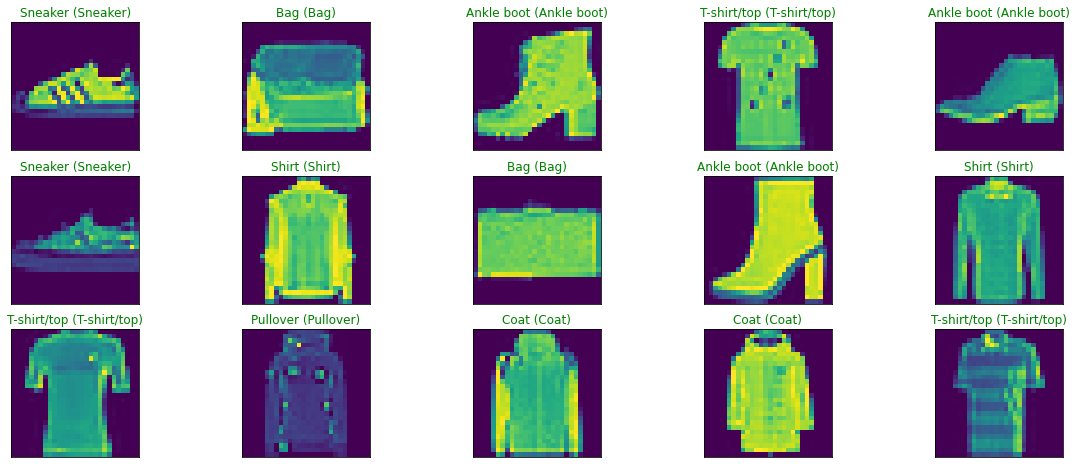

In [203]:
# Reference:
# https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=oJv7XEk10bOv
preds = final_model.predict(test_images)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(preds[index])
    true_index = np.argmax(one_hot_test_labels[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))